# 01_PyTorch_Workflow Excercises

## 1. Create a straight line dataset using the linear regression formula (weight * X + bias)

* Set `weight = 0.3` & `bias = 0.9`, there should be at least 100 datapoints total.
* Split the data into 80% training, 20% testing.
* Plot the training and testing data so it becomes visual.


In [34]:
# Necessary imports and what not
import torch
from torch import nn
import matplotlib.pyplot as plt
import pathlib as Path

torch.cuda.is_available()

True

In [2]:
# Create device agnostic code for GPU & CPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Device: {device}")

Device: cuda


In [3]:
# Create data for linear regression; y = bias + weight * X
weight = 0.3
bias = 0.9

# Data for range
start = 0
stop = 1
step = 0.01

# X (data points) & y (linear regression formula)
X =  torch.arange(start, stop, step).unsqueeze(dim=1) # Have to add a dimension or else errors
y = bias + weight * X

print(f"Weight: {weight} | Bias: {bias} | Start: {start} | Stop: {stop} | Step: {step} | Length X: {len(X)}")

Weight: 0.3 | Bias: 0.9 | Start: 0 | Stop: 1 | Step: 0.01 | Length X: 100


In [4]:
# Split data 80/20 (80% training, 20% testing)
train_split = int(0.8*len(X))

X_train, y_train = X[:train_split], y[:train_split] # ALL till 80% (80% of data for training)

X_test, y_test = X[train_split:], y[train_split:] # ALL after 80% (20% of remaining data for testing)

len(X_train), len(y_train), len(X_test), len(y_test) # Check lengths of training and testing data

(80, 80, 20, 20)

In [5]:
# Create ploting function

def plot_predictions(train_data = X_train, 
                     train_labels = y_train, 
                     test_data = X_test, 
                     test_labels = y_test, 
                     predictions = None):
    # Create figure
    plt.figure(figsize=(10, 7)) # figure(figsize=(width & height in inches))

    # Create plot points for training data
    plt.scatter(train_data, # Plot training data
                train_labels, # Plot training labels
                c='b',   # Color training data in blue
                s=4,     # Size of training data points (marker size)
                label='Training Data') # Label training data
    
    # Create plot points for test data
    plt.scatter(test_data, # Plot test data
                test_labels, # Plot test labels
                c='g',  # Color test data in green
                s=4,    # Size of test data points (marker size)
                label='Testing Data') # Label test data
    
    # Create plot points for predictions if they exist
    if predictions is not None:
        # Create plot points for predictions, assuming they exist
        plt.scatter(test_data, # Plot test data
                    predictions, # Plot predictions
                    c='r',  # Color predictions in red
                    s=4,    # Size of predictions points (marker size)
                    label='Predictions') # Label predictions
    
    # Create a info legend
    plt.legend(prop={'size': 14}) # Size of legend text

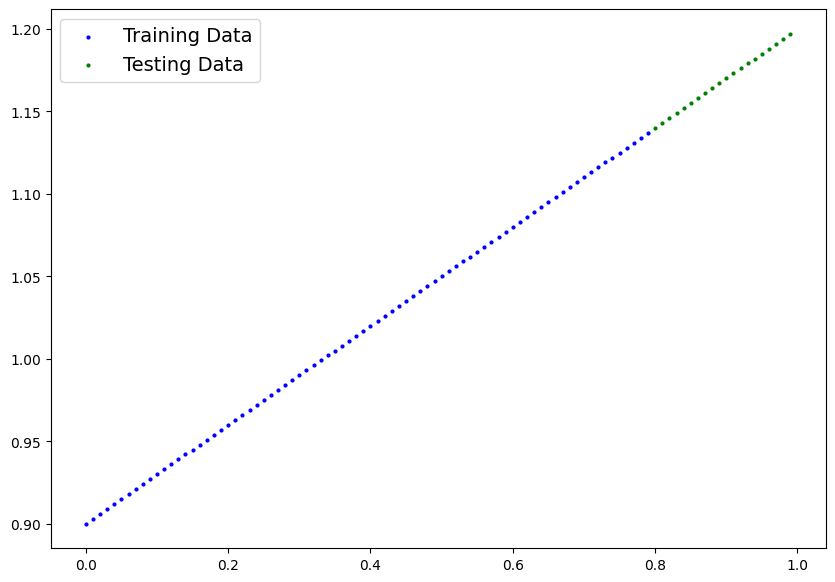

In [6]:
plot_predictions()

## 2. Build a PyTorch model by subclassing `nn.Module`.

* Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` & one for `bias`.
* Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
* Once you've constructed the model, make an instance of it and check its `state_dict()`.

In [17]:
 # Create class inheriting from nn.Module
class linearRegression(nn.Module):
    # Initialize class'
    def __init__(self):
        super().__init__()
        # Create random weight & bias parameters with gradient tracking = True
        self.weight = nn.Parameter(torch.randn(1,
                                               dtype=torch.float,
                                               requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1,
                                             dtype=torch.float,
                                             requires_grad=True))
        
    # Create forward method bc override nn.Module's forward method
    def forward(self, x: torch.Tensor) -> torch.Tensor: # Calls self.weight & self.bias as tensors
        return self.weight * x + self.bias # Linear regression formula
        
# Creat seed for reproducibility
torch.manual_seed(1337)
# Create model instance
model_E = linearRegression()

model_E, model_E.state_dict()

(linearRegression(),
 OrderedDict([('weight', tensor([-2.0260])), ('bias', tensor([-2.0655]))]))

In [20]:
next(model_E.parameters()).device # Check the models current device

device(type='cuda', index=0)

In [19]:
model_E.to(device) # Put the model on the target device
next(model_E.parameters()).device # Check the models current device

device(type='cuda', index=0)

## 3. Create a loss function and optimizer using `nn.L1Loss()` & `torch.optim.SGD(params, lr)` respectively.

* Set the learning rate of the optimizer to be 0.01 & the parameters to optimize should be the model parameters from the model you created in 2.
* Write a training loop to perform the appropriate training steps for 300 epochs.
* The training loop should test the model on the test dataset every 20 epochs.


In [21]:
# Create loss function
loss_fn = nn.L1Loss() # Mean Absolute Error

# Create optimizer w/ SGD (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params=model_E.parameters(), # Randomly adjusts the parameters of the model to minimize the loss function
                            lr=0.01) # Learning rate (how much to adjust the parameters by decimal point)

In [27]:
# Create training hyperparameters 
epochs = 3000

X_train, y_train = X_train.to(device), y_train.to(device) # Put data on the target device
X_test, y_test = X_test.to(device), y_test.to(device)     # Put data on the target device

# Training loop
for epoch in range(epochs):
    # 0. Train
    model_E.train() # Sets all parameters that require gradients to true (used for training mode)

    # 1. Forward pass
    y_pred = model_E(X_train) # Make predictions on the training data

    # 2. Calc the loss
    loss = loss_fn(y_pred, y_train) # Compare the model's predictions to the ideal values (y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad() # Set the gradients of all optimized tensors to zero

    # 4. Backward pass
    loss.backward() # Calculate the gradient of the loss with respect to the model parameters

    # 5. Optimizer step
    optimizer.step() # By default how the optimizer changes will accumulate through the loop, so we need to zero them as in step #3.

    # Testing loop
    model_E.eval() # Sets all parameters that require gradients to false (used for inference mode

    # 1. Forward pass
    with torch.inference_mode(): # turns off gradient tracking & other stuff, saves memory and computations
        test_pred = model_E(X_test) # Make predictions on the test data
        
        test_loss = loss_fn(test_pred, y_test) # Compare models predictions from ideal values (y_test)

    # Print whats happening
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.41932564973831177 | Test Loss: 0.9754301309585571
Epoch: 20 | Loss: 0.28050318360328674 | Test Loss: 0.7633636593818665
Epoch: 40 | Loss: 0.2194243222475052 | Test Loss: 0.6188602447509766
Epoch: 60 | Loss: 0.1927943080663681 | Test Loss: 0.5246787071228027
Epoch: 80 | Loss: 0.17941676080226898 | Test Loss: 0.4635174870491028
Epoch: 100 | Loss: 0.17060212790966034 | Test Loss: 0.42266589403152466
Epoch: 120 | Loss: 0.16318707168102264 | Test Loss: 0.3936598002910614
Epoch: 140 | Loss: 0.1562250852584839 | Test Loss: 0.37148386240005493
Epoch: 160 | Loss: 0.14931701123714447 | Test Loss: 0.3524034917354584
Epoch: 180 | Loss: 0.14246587455272675 | Test Loss: 0.33607470989227295
Epoch: 200 | Loss: 0.13561378419399261 | Test Loss: 0.3200899064540863
Epoch: 220 | Loss: 0.12876267731189728 | Test Loss: 0.30376115441322327
Epoch: 240 | Loss: 0.12191157788038254 | Test Loss: 0.2874324321746826
Epoch: 260 | Loss: 0.11505948752164841 | Test Loss: 0.2714475989341736
Epoch: 280 

In [28]:
model_E.state_dict()

OrderedDict([('weight', tensor([0.2920], device='cuda:0')),
             ('bias', tensor([0.8993], device='cuda:0'))])

In [23]:
weight, bias

(0.3, 0.9)

## 4. Make predictions with the trained model on the test data.

* Visualize these predictions against the original training & testing data (**note**: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

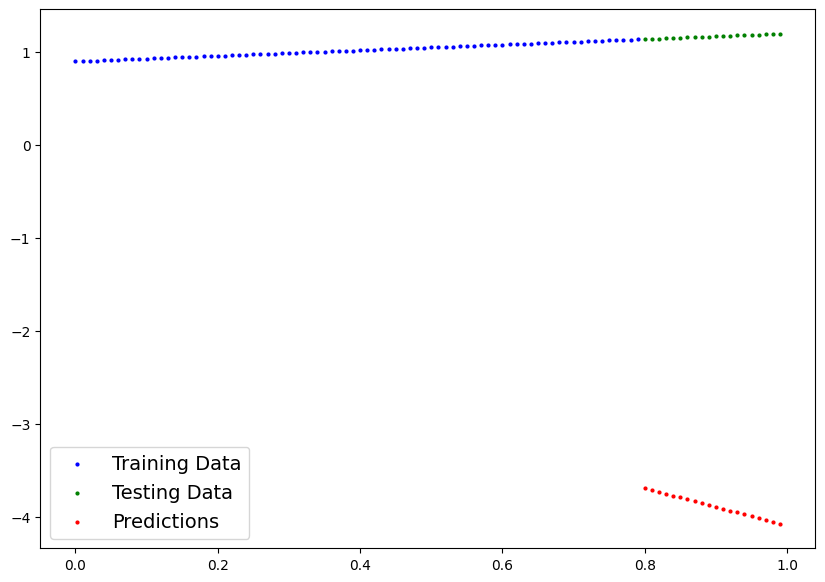

In [ ]:
'''
Plot the training & test data
'''
X_train, y_train = X_train.to(device), y_train.to(device) # Put data on the target device
X_test, y_test = X_test.to(device), y_test.to(device)     # Put data on the target device

with torch.inference_mode():
    y_preds = model_E(X_test)

plot_predictions(predictions=y_preds.cpu()) # Plot the training & test data

In [ ]:
# Put model in eval mode to plot
model_E.eval()

with torch.inference_mode():
    y_preds_new = model_E(X_test) # Make predictions on the test data

y_preds_new 

tensor([[1.1329],
        [1.1358],
        [1.1387],
        [1.1416],
        [1.1445],
        [1.1475],
        [1.1504],
        [1.1533],
        [1.1562],
        [1.1591],
        [1.1621],
        [1.1650],
        [1.1679],
        [1.1708],
        [1.1737],
        [1.1767],
        [1.1796],
        [1.1825],
        [1.1854],
        [1.1883]], device='cuda:0')

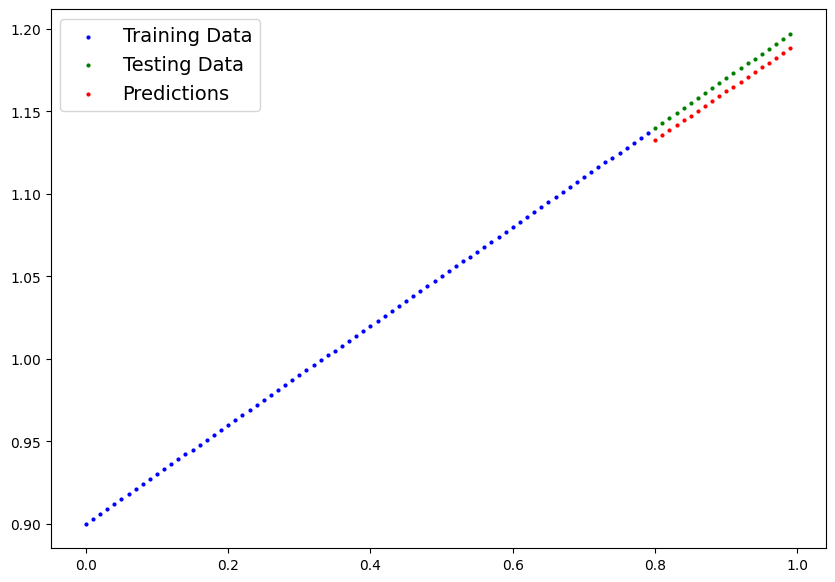

In [32]:
plot_predictions(predictions=y_preds_new.cpu()) # Plot the predictions on the test data

## 5. Save your trained model's `state_dict()` to file.

* Create a new instance of your model class you made in 2. & load in the `state_dict()` you just saved to it.
* Perform predictions on your test data with the loaded model & confirm they match the original model predictions from 4.


In [41]:
from pathlib import Path
# Create model path/directory
MODEL_PATH = Path("models") # Create a "models" file in the current directory
MODEL_PATH.mkdir(parents=True, exist_ok=True) # Makes directory (mkdir) if it doesn't exist, `exist_ok=True` means it won't raise an error if the directory already exists

# Create model save path
MODEL_NAME ="01_model_E.pth" # Name of the model file
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME # Save path for the model file
#MODEL_SAVE_PATH # Creates model save path, only run once

# Save model
torch.save(obj=model_E.state_dict(), 
           f=MODEL_SAVE_PATH) # Save the model state dict to the model save path

In [42]:
loaded_model_E = linearRegression() # Create model instance
loaded_model_E.load_state_dict(torch.load(MODEL_SAVE_PATH)) # Load the model state dict from the model save path

loaded_model_E, loaded_model_E.state_dict()

(linearRegression(),
 OrderedDict([('weight', tensor([0.2920])), ('bias', tensor([0.8993]))]))

In [50]:
loaded_model_E.to(device)

next(loaded_model_E.parameters()).device

device(type='cuda', index=0)

In [53]:
loaded_model_E.eval()
with torch.inference_mode():
    loaded_model_E_preds = loaded_model_E(X_test)




In [55]:
loaded_model_E_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

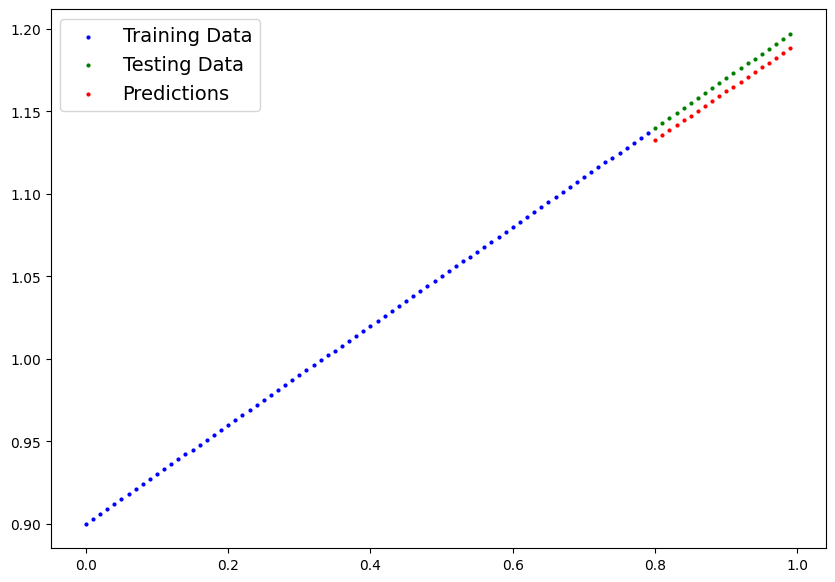

In [57]:
plot_predictions(predictions=loaded_model_E_preds.cpu())